In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
df=pd.read_csv('IndianLegalPreprocessedDataset.csv')

In [ ]:
df.head()

,title,link,fact,Result,Label,Preprocessedoutcome,Label2
0,"Kapildeo Singh vs The King on 24 January, 1950",https://indiankanoon.org/docfragment/1878796/?...,1.Thisisanappealbyspecialleaveagainstanorderof...,Rejected,0,sentenced,1
1,The State Of Bombay vs Atma Ram Sridhar Vaidya...,https://indiankanoon.org/docfragment/1382411/?...,CRIMINALAPPELLATEJURISDICTIONCaseNo.22of1950. ...,Rejected,0,appealallowed\.,1
2,The State Of West Bengal vs Anwar Ali Sarkar o...,https://indiankanoon.org/docfragment/184660633...,1.ThisisanappealbytheStateofWestBengalfromajud...,Rejected,0,sentenced,1
3,Nalinakhya Bysack vs Shyam Sunder Haldar And O...,https://indiankanoon.org/docfragment/553711/?f...,CIVILAPPELLATEJURISDICTIONCivilAppealNo.96of19...,Accepted,1,appealallowed\.,1
4,K.S. Rashid And Son vs The Income-Tax Investig...,https://indiankanoon.org/docfragment/941160/?f...,CIVILAPPELLATEJURISDICTIONCIVILAPPEALSNos. 118...,Accepted,1,appealsdismissed\.,0


In [ ]:
df = df.sample(frac=0.25, random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4991 entries, 2199 to 4514
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                4991 non-null   object
 1   link                 4991 non-null   object
 2   fact                 4991 non-null   object
 3   Result               4991 non-null   object
 4   Label                4991 non-null   int64 
 5   Preprocessedoutcome  4991 non-null   object
 6   Label2               4991 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 311.9+ KB


In [ ]:
df['Label'].value_counts()

Label
0    2884
1    2107
Name: count, dtype: int64

In [ ]:
df = pd.concat([
    df[df['Label'] == 0].sample(n=2107, replace=True),
    df[df['Label'] == 1]
])


In [ ]:
df['Label'].value_counts()

Label
0    2107
1    2107
Name: count, dtype: int64

In [ ]:
# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Load the pre-trained legal BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
base_model = AutoModelForSequenceClassification.from_pretrained("law-ai/InLegalBERT", num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at law-ai/InLegalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import os
import copy
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler

# Assuming base_model, tokenizer, train_df are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

models = []
all_epoch_losses = []
num_models = 6
num_epochs = 50
batch_size = 64



for i in range(num_models):
    model = copy.deepcopy(base_model).to(device)  # Assume base_model is defined
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)  # Adding weight decay
    loss_fn = torch.nn.CrossEntropyLoss().to(device)
    epoch_losses = []

    scaler = GradScaler()  # Initialize the gradient scaler

    start_epoch = 0


    # Learning rate scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Gradient clipping value
    clip_value = 1.0

    # Data preparation and DataLoader creation
    train_texts = train_df['fact'].tolist()  # Assume train_df is defined
    train_labels = train_df['Label'].tolist()  # Assume train_df is defined
    encoded_train = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
    train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], torch.tensor(train_labels))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch_idx, batch in enumerate(train_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()

            # Use autocast to perform forward pass in mixed precision
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            # Scales loss. Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # Scaler step. Updates the optimizer's params.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            epoch_loss += loss.item()

        # Average epoch loss
        average_epoch_loss = epoch_loss / len(train_dataloader)
        epoch_losses.append(average_epoch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_epoch_loss}")

        # Step the scheduler
        scheduler.step(average_epoch_loss)



    # Save the final model state
    # final_model_path = f'{checkpoint_dir}fine_tuned_supremecourtmodel_b64_{i}_final.pth'
    final_model_path = f'fine_tuned_supremecourtmodel_b64_{i}_final.pth'
    torch.save(model.state_dict(), final_model_path)
    models.append(model)
    all_epoch_losses.append(epoch_losses)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50] Loss: 0.7055361259658381
Epoch [2/50] Loss: 0.6994558887661628
Epoch [3/50] Loss: 0.6991689542554459
Epoch [4/50] Loss: 0.697922777454808
Epoch [5/50] Loss: 0.6961239688801315
Epoch [6/50] Loss: 0.6992338985767005
Epoch [7/50] Loss: 0.6991979637235965
Epoch [8/50] Loss: 0.6948953619543111
Epoch [9/50] Loss: 0.6941662801886505
Epoch [10/50] Loss: 0.6941063977637381
Epoch [11/50] Loss: 0.6928259696600572
Epoch [12/50] Loss: 0.691165177327282
Epoch [13/50] Loss: 0.6889842973565156
Epoch [14/50] Loss: 0.6887499352671066
Epoch [15/50] Loss: 0.6844358590413939
Epoch [16/50] Loss: 0.6853869591119155
Epoch [17/50] Loss: 0.6817152556383385
Epoch [18/50] Loss: 0.6786027798112834
Epoch [19/50] Loss: 0.670630932978864
Epoch [20/50] Loss: 0.6604891284456793
Epoch [21/50] Loss: 0.6548705472136443
Epoch [22/50] Loss: 0.6451802309953941
Epoch [23/50] Loss: 0.6277004795254402
Epoch [24/50] Loss: 0.6171509691004483
Epoch [25/50] Loss: 0.6054488499209566
Epoch [26/50] Loss: 0.585572217995265

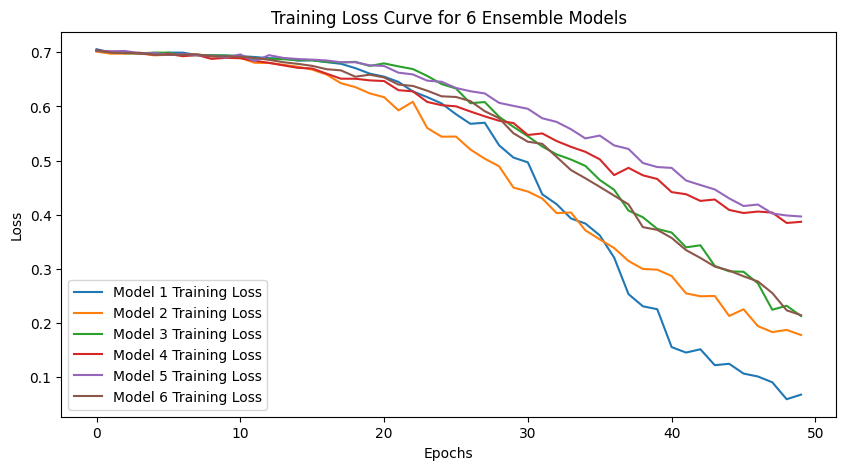

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(all_epoch_losses[0], label='Model 1 Training Loss')
plt.plot(all_epoch_losses[1], label='Model 2 Training Loss')
plt.plot(all_epoch_losses[2], label='Model 3 Training Loss')
plt.plot(all_epoch_losses[3], label='Model 4 Training Loss')
plt.plot(all_epoch_losses[4], label='Model 5 Training Loss')
plt.plot(all_epoch_losses[5], label='Model 6 Training Loss')
plt.title('Training Loss Curve for 6 Ensemble Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(input_ids.device)

cuda:0


In [ ]:
print(model.get_input_embeddings().weight.device)

cuda:0


In [ ]:
model.to(input_ids.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Generate predictions for each model
all_preds = []

for model in models:
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Ensure the model is on the correct device

    # Tokenize and preprocess the testing data
    test_texts = test_df['fact'].tolist()
    test_labels = test_df['Label'].tolist()

    encoded_test = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')
    test_dataset = TensorDataset(encoded_test['input_ids'], encoded_test['attention_mask'], torch.tensor(test_labels))

    # Create DataLoader for testing data
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model_preds = []

    with torch.no_grad():  # No need to track gradients for inference
        for batch in test_dataloader:
            input_ids, attention_mask, _ = batch  # Labels are not needed for prediction

            # Move the batch to the same device as the model
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            model_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU for further processing/storage

    all_preds.append(model_preds)

In [ ]:
# Combine predictions using majority voting
ensemble_preds = [max(set(preds), key=preds.count) for preds in zip(*all_preds)]
test_labels = test_df['Label'].tolist()


In [ ]:
# Calculate metrics
accuracy = accuracy_score(test_labels, ensemble_preds)
precision = precision_score(test_labels, ensemble_preds, average='weighted')
recall = recall_score(test_labels, ensemble_preds, average='weighted')
f1 = f1_score(test_labels, ensemble_preds, average='weighted')


In [ ]:
print(f"Ensemble Accuracy: {accuracy}")
print(f"Ensemble Precision: {precision}")
print(f"Ensemble Recall: {recall}")
print(f"Ensemble F1 Score: {f1}")

Ensemble Accuracy: 0.7188612099644128
Ensemble Precision: 0.7193409118798738
Ensemble Recall: 0.7188612099644128
Ensemble F1 Score: 0.7170183877432427


In [ ]:
# Classification Report and Confusion Matrix
print("Ensemble Classification Report:")
print(classification_report(test_labels, ensemble_preds))
print("Ensemble Confusion Matrix:")
print(confusion_matrix(test_labels, ensemble_preds))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       450
           1       0.72      0.64      0.68       393

    accuracy                           0.72       843
   macro avg       0.72      0.71      0.71       843
weighted avg       0.72      0.72      0.72       843

Ensemble Confusion Matrix:
[[354  96]
 [141 252]]
